

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## Configuration


In [1]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
# pip install -U seaborn

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# set gpu memory
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
%reload_ext autoreload

### Initial Parameters

In [4]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

notebook_name_params = qbz95.utils.get_notebook_name().split('.')[0].split('_')
train_image_count =  int(notebook_name_params[3])
use_data_augmentation = True if len(notebook_name_params)>=5 and notebook_name_params[4]=='aug' else False

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': use_data_augmentation,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*len(classes)/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },    
    'pretrained_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': False,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': False,
            'schedule': lr_schedule,            
        }             
    },
    'fine_tune_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        }            
    },    
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':90},
        'lenet':{'dropout':0.2, 'epochs':90},
        'custom':{'dropout':0.2, 'epochs':90},
        'vgg':{'dropout':0.1, 'epochs':90},
        'resnet':{'dropout':0.2, 'epochs':90},
        'pretrained':{'dropout':0.2, 'epochs':20, 'learning_rate':0.0001}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
model_results.clear()

In [5]:
params.use_data_augmentation

True

## Get Data

### Download Data 

In [6]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# train_images = train_images/255.0   
# test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [7]:
if params.train_image_count*len(classes)<len(train_images):
    _, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)

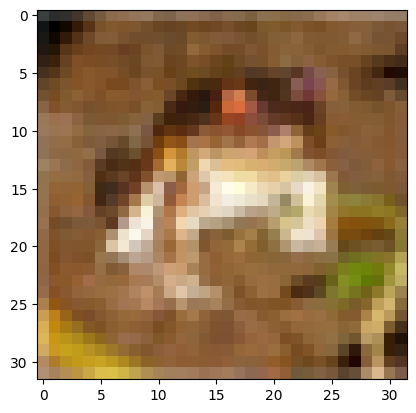

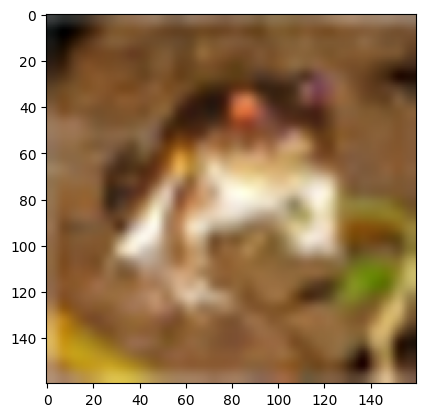

(32, 32, 3) (160, 160, 3)


In [8]:
def resize_image(image, shape=None):
    img = Image.fromarray(image)
    if shape is not None:
        img = img.resize(shape)
    image1 = np.asarray(img)
    return image1

def resize_images(images, shape=None):
    images1 = [resize_image(image, shape) for image in images]
    images1 = np.array(images1)
    return images1

input_shape=(160, 160) 
images = train_images[0:10]
images1 = resize_images(images, input_shape)

image_array = images[0]
plt.imshow(image_array)
plt.show()
 
image_array1 = images1[0]
plt.imshow(image_array1)
plt.show()

print(image_array.shape, image_array1.shape) 
# np.testing.assert_array_almost_equal(image_array, image_array1)

In [9]:
# train_images = resize_images(train_images, input_shape)
# test_images = resize_images(test_images, input_shape)

# print(train_images.shape, type(train_images), train_images.dtype)
# print(test_images.shape, type(test_images), test_images.dtype) 



### Data Explore 

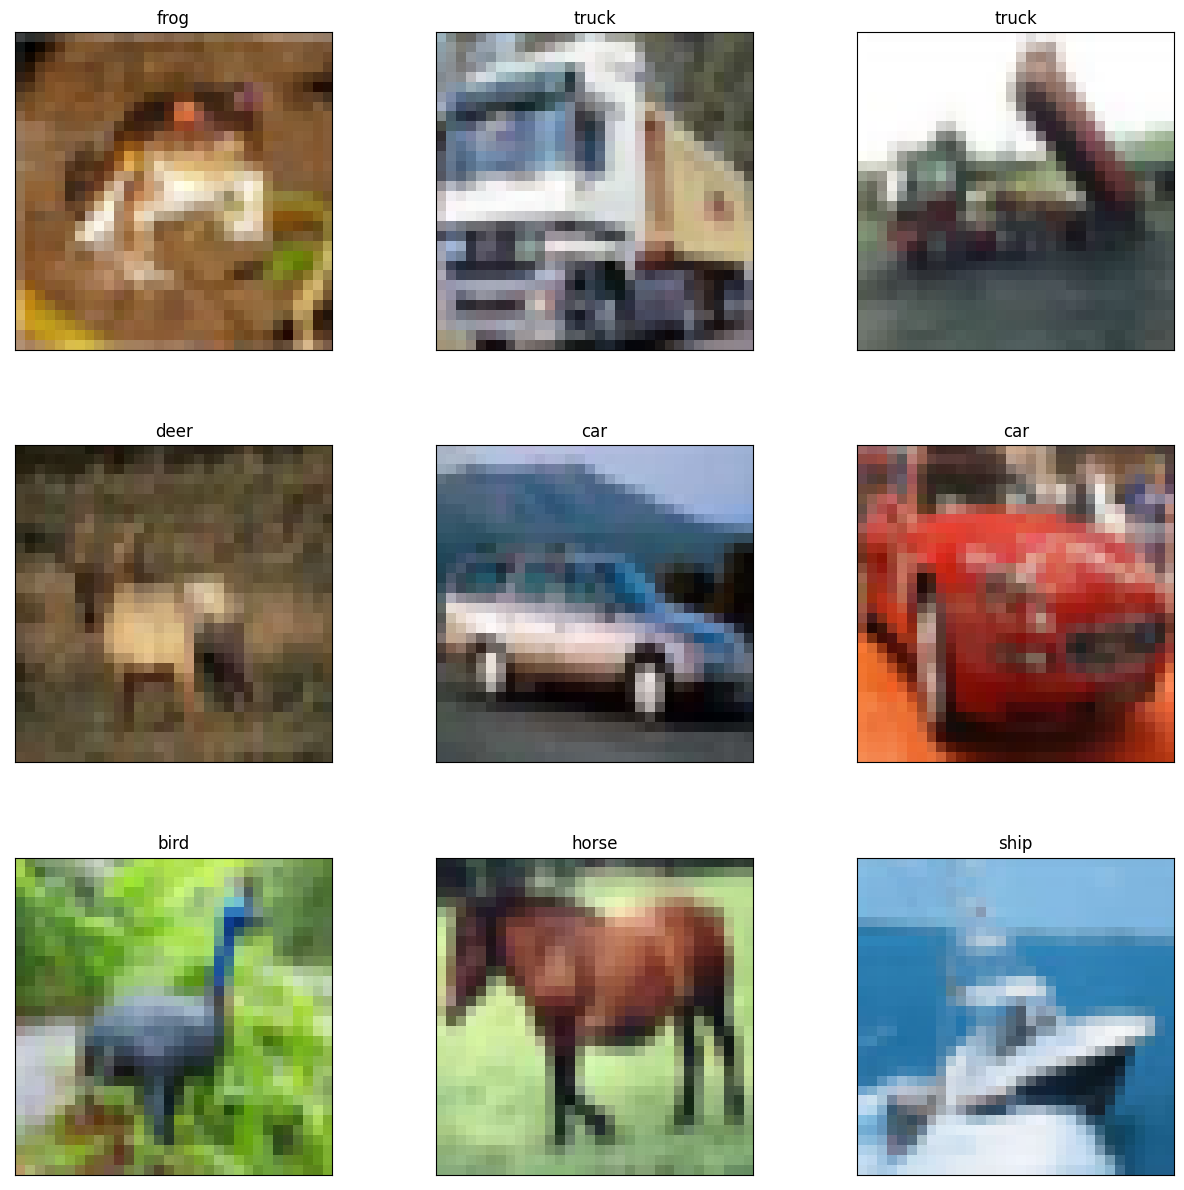

In [10]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=3, figsize=(12, 12))

### Class Distribution

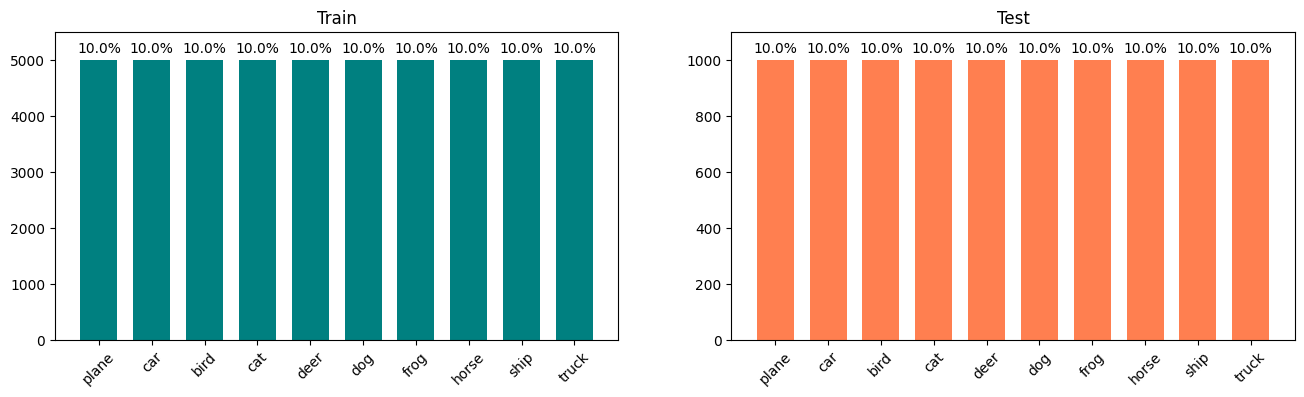

In [11]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## Prepare Data


### Raw Data


In [12]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [13]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [14]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

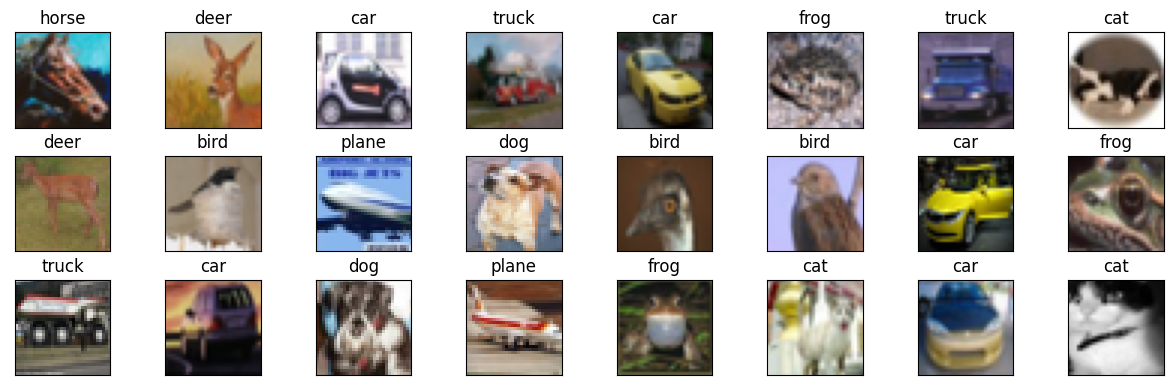

In [15]:
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Data Augmentation

In [16]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

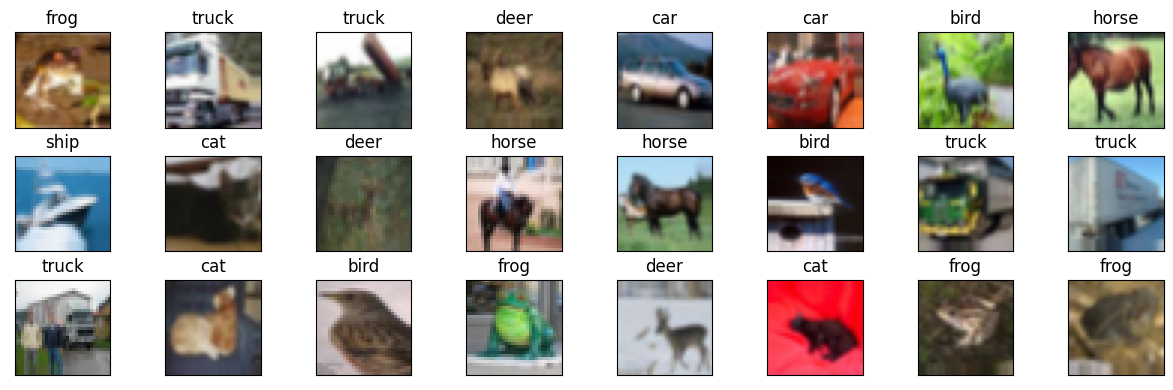

In [17]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

see orgin images

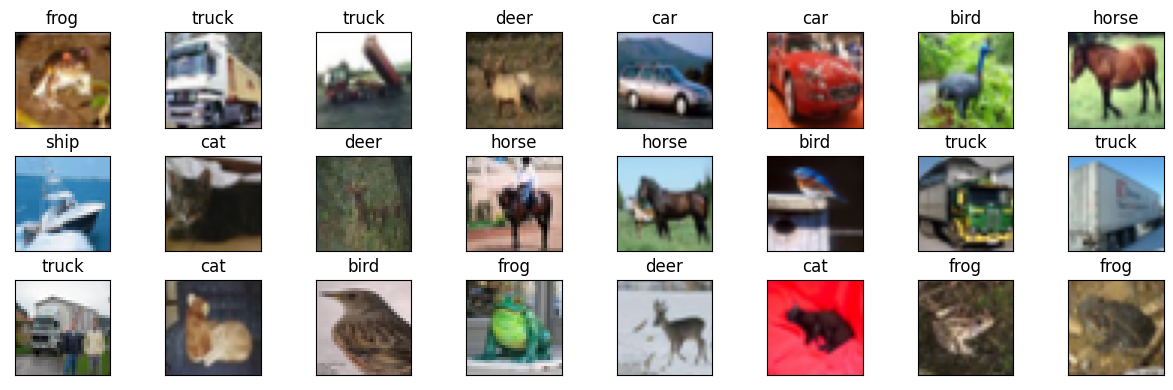

In [18]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

create data augment dataset

In [19]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [20]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = True


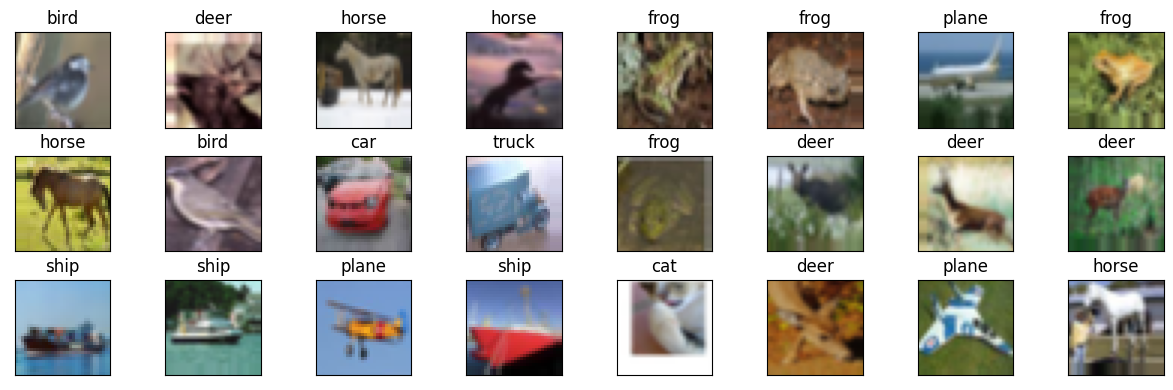

In [21]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

In [22]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


(32, 32, 3) <dtype: 'uint8'> <class 'tensorflow.python.framework.ops.EagerTensor'>


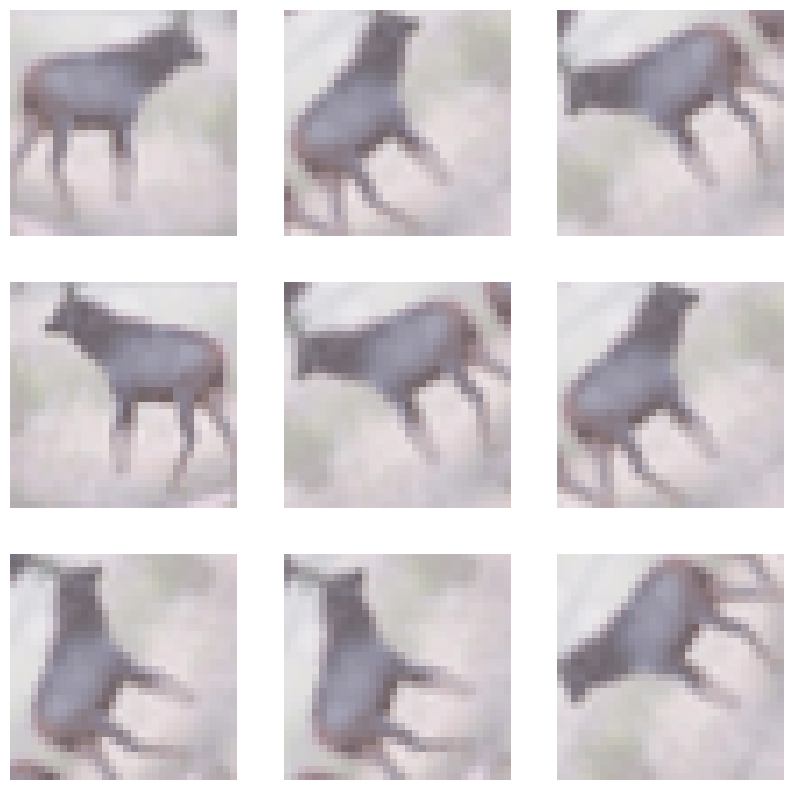

In [30]:
augmented_images = []
for image, _ in raw_datasets.train_dataset.take(1): 
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    print(first_image.shape, first_image.dtype, type(first_image)) 

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')
        augmented_images.append(augmented_image) 
plt.show() 

In [31]:
rescale = tf.keras.layers.Rescaling(1./255.0, offset=0)

In [32]:
# if params.use_data_augmentation:
#     preprocess_fun = [data_augmentation, rescale]
# else:
preprocess_fun = rescale
    
print(preprocess_fun)



##  Models



### MLP

In [34]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1', preprocess_fun=preprocess_fun)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

2022-08-17 04:53:47,991: INFO: model_params.mlp1.dropout=0.1
2022-08-17 04:53:47,992: INFO: model_params.mlp1.layer_count=1
2022-08-17 04:53:47,993: INFO: model_params.mlp1.units=128
2022-08-17 04:53:48,026: INFO: learning_rate=0.001
2022-08-17 04:53:48,026: INFO: model_params.mlp1.clip_value=None
2022-08-17 04:53:48,032: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/mlp1


Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               393344    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable 

2022-08-17 04:53:48,046: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/mlp1, monitor=val_accuracy)
2022-08-17 04:53:48,047: INFO: model_params.mlp1.epochs=90
2022-08-17 04:53:48,047: INFO: steps_per_epoch=1562
2022-08-17 04:53:48,048: INFO: start training
2022-08-17 04:53:48,049: INFO: use_class_weight=False


Epoch 1/90
 973/1562 [=================>............] - ETA: 12s - loss: 2.0890 - accuracy: 0.2256

2022-08-17 04:54:08,503: INFO: finish training [elapsed time: 20.45 seconds]


KeyboardInterrupt: 




### LeNet

![image-20201019113632136](images/image-20201019113632136.png)


In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Custom 1


In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1', preprocess_fun=preprocess_fun)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### VGG

In [ ]:
rescale1 = tf.keras.layers.Rescaling(1./255.0)
for data, label in datasets.train_dataset.take(1):
    print(data[0][0][0:5]) 
    print(rescale(data)[0][0][0:5])  

In [ ]:

helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3, 
                                             preprocess_fun=preprocess_fun)
model.summary()


In [ ]:
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Resnet

see https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20, preprocess_fun=preprocess_fun)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Pretrained Model + Fune-Tune

In [35]:
class ResizeLayer(tf.keras.layers.Layer):
    def __init__(self, shape):
        super(ResizeLayer, self).__init__()
        self.shape = shape

    def call(self, inputs, training=False):
#         print(type(inputs))
#         return tf.convert_to_tensor(resize_images(inputs.numpy(), self.shape))
        return tf.image.resize(inputs, self.shape)

In [36]:
rescale1 = tf.keras.layers.Rescaling(1./127.5, offset=-1)
input_shape = [160, 160, 3]

In [37]:
# if params.use_data_augmentation:
#     preprocess_fun = [data_augmentation, ResizeLayer(input_shape[:-1]), rescale1]
# else:
preprocess_fun =  [ResizeLayer(input_shape[:-1]), rescale1]

print(preprocess_fun)

[<__main__.ResizeLayer object at 0x7f56646f0970>, <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f57bdfecfd0>]


(32, 160, 160, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


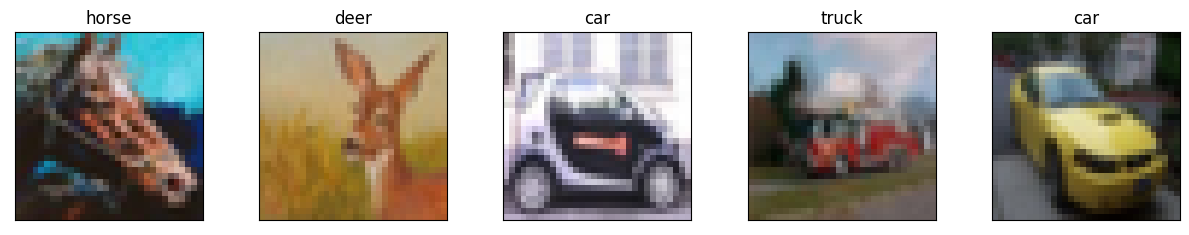

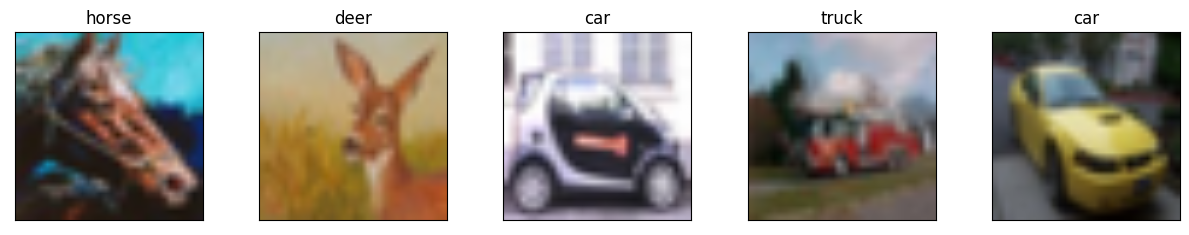

In [38]:
sample_images1 = ResizeLayer(input_shape[:-1])(sample_images)
print(sample_images1.shape, type(sample_images1)) 
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))
qtf.utils.show_images(sample_images1.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))

#### MobileNet V2

In [39]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [40]:
def pretrained_model(helper, base_model, dropout=None, name='pretrained_model', last_activation=None, preprocess_fun=None):
    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')

    input_shape = qbz95.tf.classification.get_input_shape(helper.datasets.train_dataset)
    input = layers.Input(shape=input_shape)
    x = qbz95.tf.classification.image_models.process_funs(input, preprocess_fun)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = helper.get_dense_layer(len(helper.params.classes), activation=last_activation)(x)

    model = Model(inputs=input, outputs=x, name=name)
    helper.compile(model)
    return model

def fine_tuning(helper, model, base_model, fine_tune_at, learning_rate=0.00001):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=helper.params.metrics)
    return model 

In [41]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = pretrained_model(helper, base_model, dropout=0.2, name='pretrained-MobileNetV2', preprocess_fun=preprocess_fun)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')
model.summary()

loss0, accuracy0 = model.evaluate(datasets.test_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2022-08-17 04:54:22,858: INFO: model_params.pretrained-MobileNetV2.learning_rate=0.0001
2022-08-17 04:54:22,859: INFO: model_params.pretrained-MobileNetV2.clip_value=None
2022-08-17 04:54:22,867: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2


len(model.trainable_variables)=2
Model: "pretrained-MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resize_layer (ResizeLayer)  (None, 160, 160, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_2 

2022-08-17 04:54:32,993: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-17 04:54:32,993: INFO: steps_per_epoch=1562
2022-08-17 04:54:32,994: INFO: start training
2022-08-17 04:54:32,995: INFO: use_class_weight=False


Epoch 1/10
1561/1562 [============================>.] - ETA: 0s - loss: 1.2286 - accuracy: 0.5814

2022-08-17 04:55:36,417: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


2022-08-17 04:55:41,273: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 69s 42ms/step - loss: 1.2282 - accuracy: 0.5816 - val_loss: 0.6432 - val_accuracy: 0.7812
Epoch 2/10
1561/1562 [============================>.] - ETA: 0s - loss: 0.7545 - accuracy: 0.7416

2022-08-17 04:56:51,952: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


2022-08-17 04:56:56,705: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 75s 48ms/step - loss: 0.7545 - accuracy: 0.7416 - val_loss: 0.5370 - val_accuracy: 0.8131
Epoch 3/10
1562/1562 [==============================] - ETA: 0s - loss: 0.6736 - accuracy: 0.7685

2022-08-17 04:58:07,407: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


2022-08-17 04:58:12,517: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 76s 49ms/step - loss: 0.6736 - accuracy: 0.7685 - val_loss: 0.4988 - val_accuracy: 0.8262
Epoch 4/10
1562/1562 [==============================] - ETA: 0s - loss: 0.6344 - accuracy: 0.7822

2022-08-17 04:59:22,868: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


2022-08-17 04:59:27,616: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 75s 48ms/step - loss: 0.6344 - accuracy: 0.7822 - val_loss: 0.4741 - val_accuracy: 0.8355
Epoch 5/10
1561/1562 [============================>.] - ETA: 0s - loss: 0.6093 - accuracy: 0.7907

2022-08-17 05:00:38,843: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


2022-08-17 05:00:43,742: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 76s 49ms/step - loss: 0.6091 - accuracy: 0.7908 - val_loss: 0.4611 - val_accuracy: 0.8413
Epoch 6/10
1560/1562 [============================>.] - ETA: 0s - loss: 0.5888 - accuracy: 0.7981

2022-08-17 05:01:55,848: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


2022-08-17 05:02:00,554: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 77s 49ms/step - loss: 0.5886 - accuracy: 0.7982 - val_loss: 0.4480 - val_accuracy: 0.8449
Epoch 7/10
1562/1562 [==============================] - 51s 33ms/step - loss: 0.5725 - accuracy: 0.8023 - val_loss: 0.4519 - val_accuracy: 0.8435
Epoch 8/10
1562/1562 [==============================] - ETA: 0s - loss: 0.5661 - accuracy: 0.8060

2022-08-17 05:04:01,715: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


2022-08-17 05:04:06,983: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 75s 48ms/step - loss: 0.5661 - accuracy: 0.8060 - val_loss: 0.4285 - val_accuracy: 0.8530
Epoch 9/10
1561/1562 [============================>.] - ETA: 0s - loss: 0.5524 - accuracy: 0.8088

2022-08-17 05:05:17,166: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


2022-08-17 05:05:21,776: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 75s 48ms/step - loss: 0.5523 - accuracy: 0.8089 - val_loss: 0.4271 - val_accuracy: 0.8551
Epoch 10/10
1562/1562 [==============================] - 51s 32ms/step - loss: 0.5469 - accuracy: 0.8115 - val_loss: 0.4284 - val_accuracy: 0.8521


2022-08-17 05:06:13,373: INFO: finish training [elapsed time: 700.38 seconds]


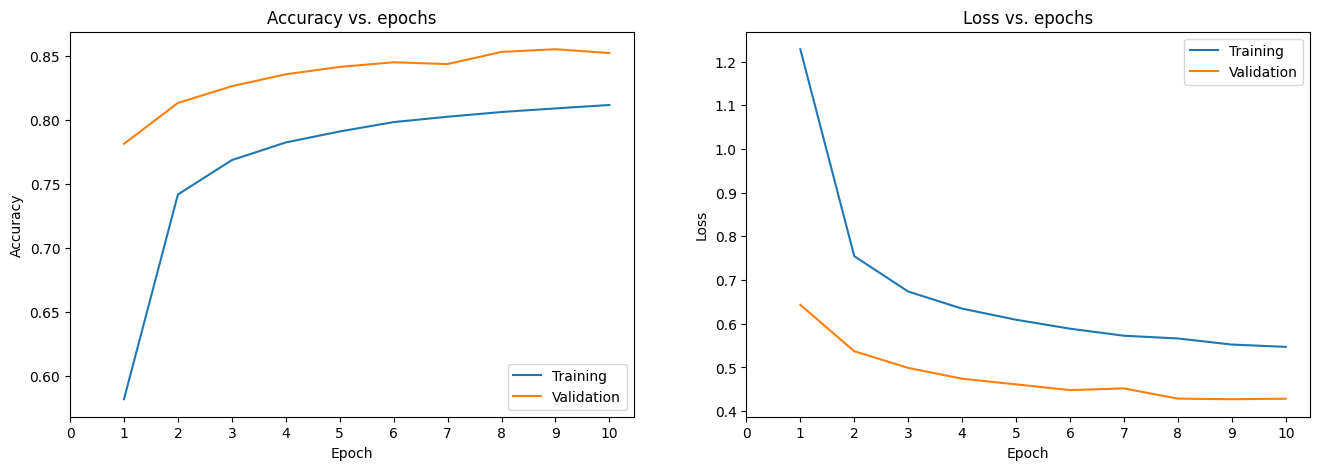

In [42]:
history = helper.train(model, epochs=10, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))

In [43]:
model = fine_tuning(helper, model, base_model, fine_tune_at=100, learning_rate=0.00001)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')

len(model.trainable_variables)=56


2022-08-17 05:06:13,887: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-17 05:06:13,888: INFO: steps_per_epoch=1562
2022-08-17 05:06:13,889: INFO: start training
2022-08-17 05:06:13,889: INFO: use_class_weight=False


Epoch 1/15
1562/1562 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.8346

2022-08-17 05:07:58,259: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


2022-08-17 05:08:03,042: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 110s 67ms/step - loss: 0.4765 - accuracy: 0.8346 - val_loss: 0.3256 - val_accuracy: 0.8880
Epoch 2/15
1562/1562 [==============================] - 77s 49ms/step - loss: 0.3874 - accuracy: 0.8670 - val_loss: 0.3342 - val_accuracy: 0.8862
Epoch 3/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.8819

2022-08-17 05:10:57,613: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


2022-08-17 05:11:02,837: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 103s 66ms/step - loss: 0.3381 - accuracy: 0.8819 - val_loss: 0.2833 - val_accuracy: 0.9040
Epoch 4/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.3060 - accuracy: 0.8944

2022-08-17 05:12:38,086: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


2022-08-17 05:12:43,225: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 100s 64ms/step - loss: 0.3061 - accuracy: 0.8943 - val_loss: 0.2625 - val_accuracy: 0.9119
Epoch 5/15
1562/1562 [==============================] - 79s 50ms/step - loss: 0.2795 - accuracy: 0.9027 - val_loss: 0.2790 - val_accuracy: 0.9089
Epoch 6/15
1562/1562 [==============================] - 85s 54ms/step - loss: 0.2561 - accuracy: 0.9093 - val_loss: 0.2721 - val_accuracy: 0.9115
Epoch 7/15
1562/1562 [==============================] - ETA: 0s - loss: 0.2395 - accuracy: 0.9164

2022-08-17 05:17:09,817: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


2022-08-17 05:17:15,436: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 109s 70ms/step - loss: 0.2395 - accuracy: 0.9164 - val_loss: 0.2653 - val_accuracy: 0.9135
Epoch 8/15
1562/1562 [==============================] - ETA: 0s - loss: 0.2221 - accuracy: 0.9224

2022-08-17 05:18:59,165: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


2022-08-17 05:19:04,199: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 109s 70ms/step - loss: 0.2221 - accuracy: 0.9224 - val_loss: 0.2428 - val_accuracy: 0.9217
Epoch 9/15
1562/1562 [==============================] - ETA: 0s - loss: 0.2079 - accuracy: 0.9267

2022-08-17 05:20:51,975: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


2022-08-17 05:20:57,114: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 113s 72ms/step - loss: 0.2079 - accuracy: 0.9267 - val_loss: 0.2367 - val_accuracy: 0.9226
Epoch 10/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.1985 - accuracy: 0.9316

2022-08-17 05:22:35,589: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


2022-08-17 05:22:41,136: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 104s 67ms/step - loss: 0.1984 - accuracy: 0.9316 - val_loss: 0.2149 - val_accuracy: 0.9297
Epoch 11/15
1562/1562 [==============================] - 82s 52ms/step - loss: 0.1841 - accuracy: 0.9368 - val_loss: 0.2286 - val_accuracy: 0.9269
Epoch 12/15
1562/1562 [==============================] - 82s 53ms/step - loss: 0.1769 - accuracy: 0.9385 - val_loss: 0.2230 - val_accuracy: 0.9293
Epoch 13/15
1562/1562 [==============================] - 78s 50ms/step - loss: 0.1661 - accuracy: 0.9419 - val_loss: 0.2334 - val_accuracy: 0.9273
Epoch 14/15
1562/1562 [==============================] - 82s 52ms/step - loss: 0.1588 - accuracy: 0.9442 - val_loss: 0.2283 - val_accuracy: 0.9296
Epoch 15/15
1561/1562 [============================>.] - ETA: 0s - loss: 0.1496 - accuracy: 0.9467

2022-08-17 05:29:42,926: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


2022-08-17 05:29:47,723: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2/assets


1562/1562 [==============================] - 103s 66ms/step - loss: 0.1496 - accuracy: 0.9467 - val_loss: 0.2324 - val_accuracy: 0.9312


2022-08-17 05:29:48,506: INFO: finish training [elapsed time: 1414.62 seconds]


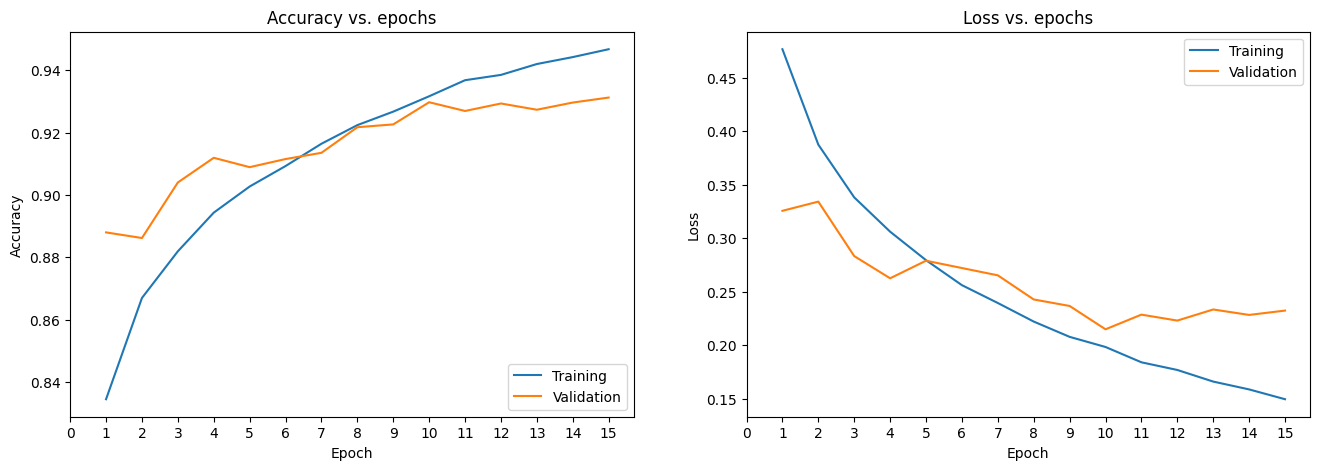

2022-08-17 05:29:48,908: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 8s 25ms/step


2022-08-17 05:31:42,461: INFO: test loss:0.2324
2022-08-17 05:31:42,462: INFO: test accuracy:0.9312
2022-08-17 05:31:42,466: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/results.json
2022-08-17 05:31:42,467: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/results.json
2022-08-17 05:31:42,468: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/val_test.generator
2022-08-17 05:31:42,470: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/val_test.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------
313/313 [==============================] - 8s 25ms/step


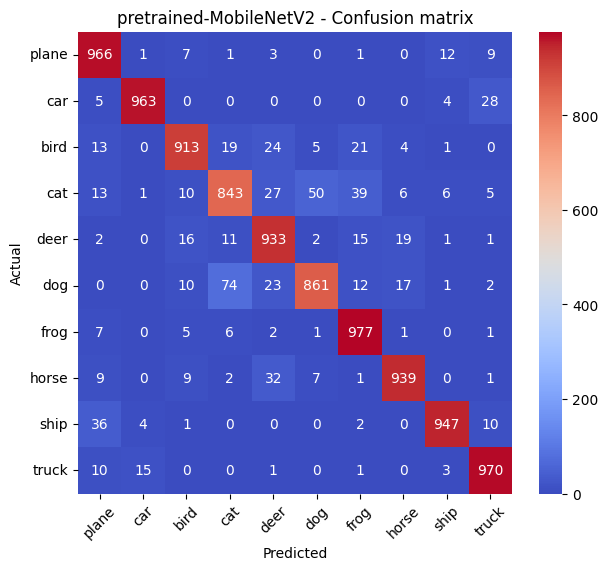

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,pretrained-MobileNetV2,cifar10_0816_cnt_5000_aug_1.ipynb,1874250,1414.6,2022-08-17 05:31,0.1048,0.2324,0.963,0.9312,0.9992,0.9967


In [44]:
history = helper.train(model, epochs=15, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))
helper.model_summary(model, history, show_sample_analysis=False) 

## Evaluation

### Best Model

In [45]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(20)

2022-08-17 05:31:51,421: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2022-08-17 05:31:51,423: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-17 05:31:51,425: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-17 05:31:51,426: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-17 05:31:51,427: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-17 05:31:51,428: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/ima

,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,pretrained-MobileNetV2,cifar10_0816_cnt_5000_aug_1.ipynb,1874250,1414.6,2022-08-17 05:31,0.1048,0.2324,0.9630,0.9312,0.9992,0.9967
2,pretrained-MobileNetV2,cifar10_0816_cnt_5000.ipynb,1874250,1096.1,2022-08-16 12:32,0.0215,0.3150,0.9938,0.9260,1.0000,0.9964
3,pretrained-MobileNetV2,cifar10_0816_cnt_2000.ipynb,1874250,762.3,2022-08-16 11:22,0.0112,0.4282,0.9976,0.9058,1.0000,0.9944
4,pretrained-MobileNetV2,cifar10_0816_cnt_1000.ipynb,1874250,598.4,2022-08-16 09:26,0.0212,0.4112,0.9963,0.8930,1.0000,0.9929
5,vgg8,cifar10_0816_cnt_5000.ipynb,1672906,2113.1,2022-08-16 11:13,0.0005,0.8218,0.9999,0.8845,1.0000,0.9893
6,pretrained-MobileNetV2,cifar10_0816_cnt_500.ipynb,1874250,487.0,2022-08-16 09:53,0.0125,0.4696,0.9992,0.8778,1.0000,0.9906
7,pretrained-MobileNetV2,cifar10_0816_cnt_200.ipynb,1874250,427.4,2022-08-16 09:54,0.0315,0.5364,0.9960,0.8412,1.0000,0.9857
8,vgg8,cifar10_0816_cnt_2000.ipynb,1672906,1019.2,2022-08-16 10:31,0.0003,1.2263,1.0000,0.8299,1.0000,0.9791
9,resnet_v1_20,cifar10_0816_cnt_5000.ipynb,273066,2852.6,2022-08-16 12:02,0.1742,1.3372,0.9971,0.8207,1.0000,0.9796
10,pretrained-MobileNetV2,cifar10_0816_cnt_100.ipynb,1874250,399.4,2022-08-16 09:37,0.0413,0.6508,0.9950,0.8021,0.9999,0.9788


In [46]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-17 05:31:51,515: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2
2022-08-17 05:32:02,150: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/val_test.generator
2022-08-17 05:32:02,173: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2
2022-08-17 05:32:12,470: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator
2022-08-17 05:32:12,493: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2
2022-08-17 05:32:24,240: INFO: loading 

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

In [47]:
predictors[0].classes

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

1/1 [==============================] - 1s 876ms/step


2022-08-17 05:32:41,333: WARNING: 5 out of the last 2193 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f55106ad700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 1s 902ms/step


2022-08-17 05:32:41,591: WARNING: 6 out of the last 2194 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f55104f5d30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 10ms/step


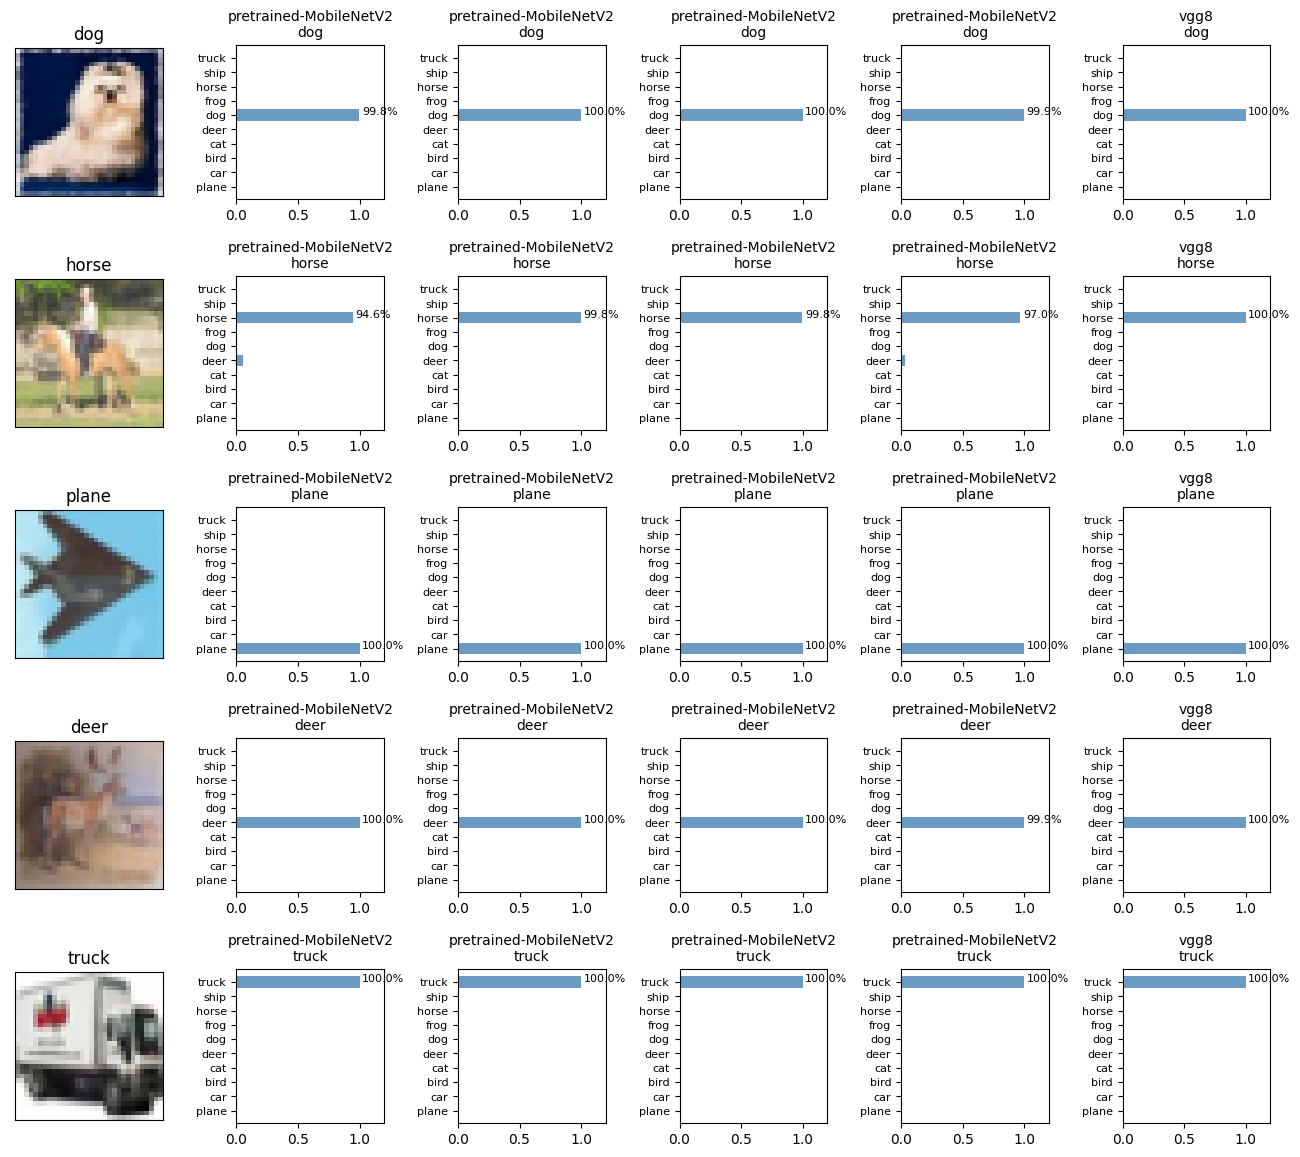

In [48]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                     sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 10ms/step


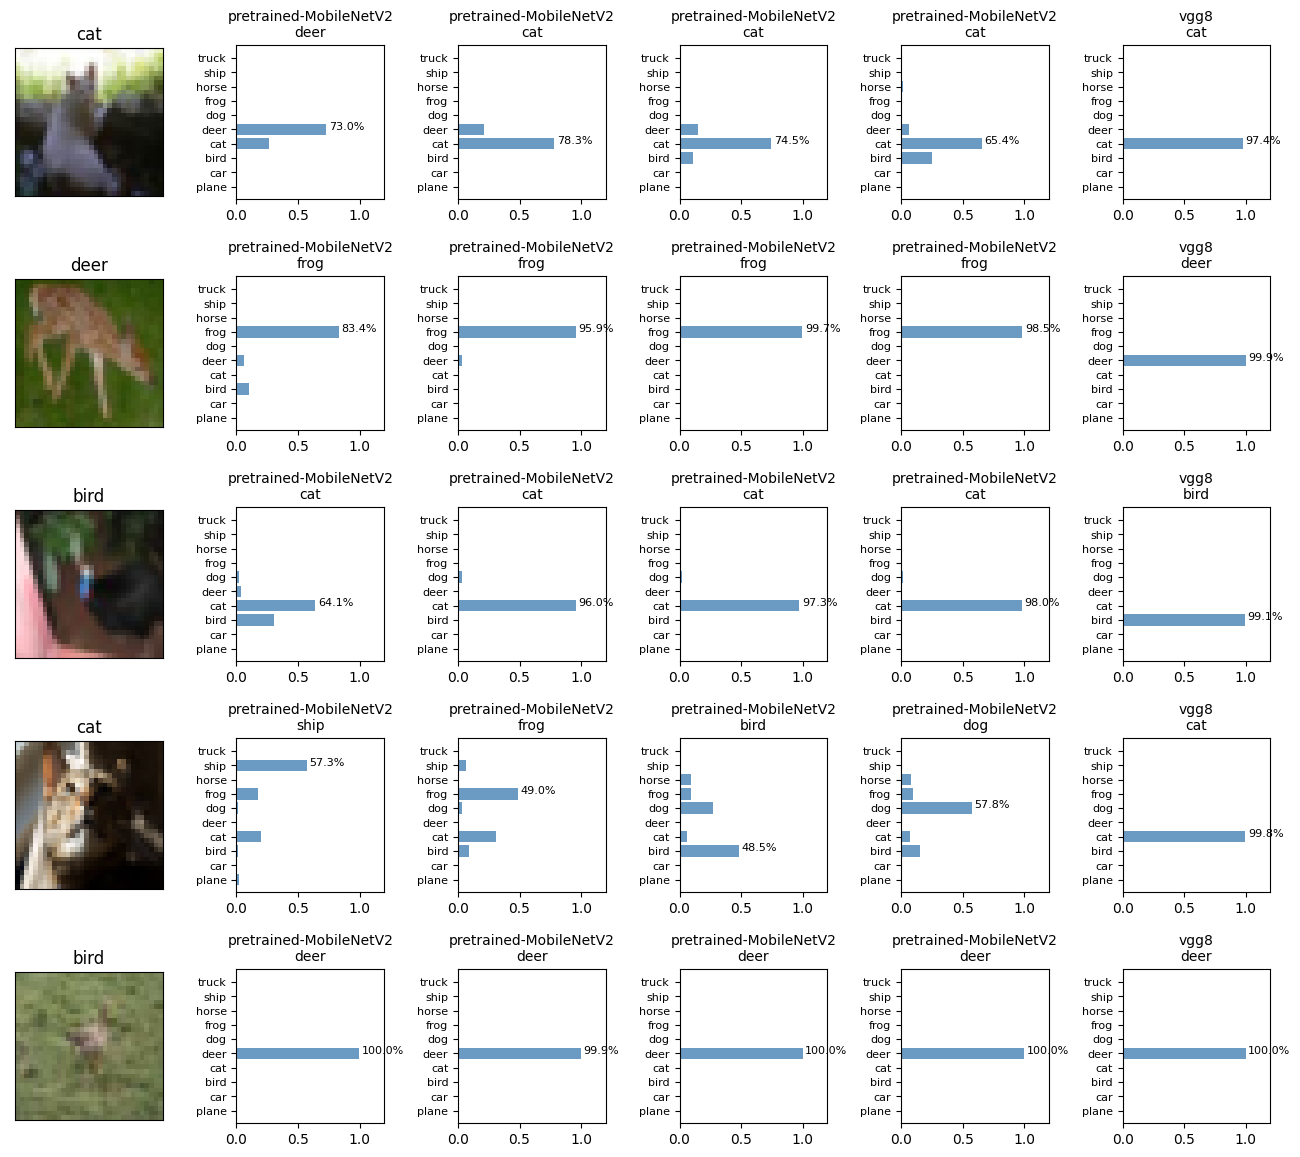

In [49]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### Evaluate

In [50]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.23238687217235565, 'accuracy': 0.9312000274658203, 'mae': 10.514875411987305}
313/313 [==============================] - 8s 26ms/step
(10000, 10)


In [51]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

313/313 [==============================] - 8s 25ms/step


,precision,recall,f1
plane,0.910462,0.966,0.937409
car,0.978659,0.963,0.970766
bird,0.940268,0.913,0.926433
cat,0.881799,0.843,0.861963
deer,0.892823,0.933,0.912469
dog,0.929806,0.861,0.894081
frog,0.913938,0.977,0.944418
horse,0.952333,0.939,0.945619
ship,0.971282,0.947,0.958987
truck,0.944499,0.970,0.957079


----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.9105    0.9660    0.9374      1000
         car     0.9787    0.9630    0.9708      1000
        bird     0.9403    0.9130    0.9264      1000
         cat     0.8818    0.8430    0.8620      1000
        deer     0.8928    0.9330    0.9125      1000
         dog     0.9298    0.8610    0.8941      1000
        frog     0.9139    0.9770    0.9444      1000
       horse     0.9523    0.9390    0.9456      1000
        ship     0.9713    0.9470    0.9590      1000
       truck     0.9445    0.9700    0.9571      1000

    accuracy                         0.9312     10000
   macro avg     0.9316    0.9312    0.9309     10000
weighted avg     0.9316    0.9312    0.9309     10000



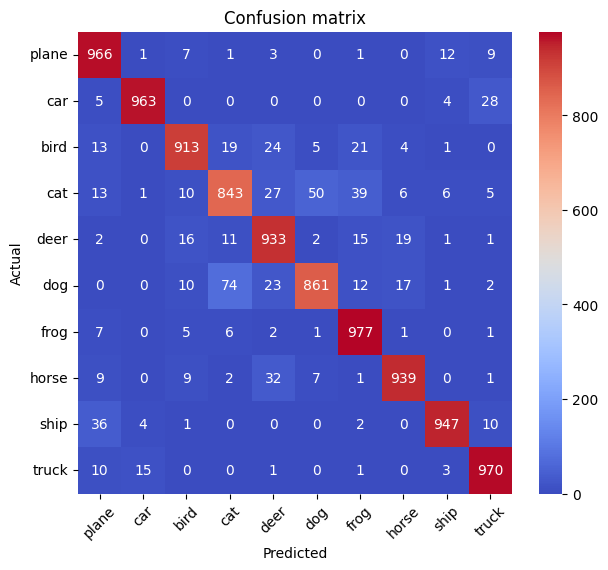

In [52]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## Reference

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)